# Beer Choozamatron 3000


#### Customized Recommendation: Collaborative filtering and Content-based recommendation system

#### "collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users" 




In [2]:
import numpy as np
import sklearn
import pandas as pd

In [3]:
beer_data = pd.read_csv('beer_reviews.csv', delimiter=",", encoding='utf-8')

In [7]:
beer_df = beer_data[["beer_beerid","beer_name","review_overall", "review_profilename"]]
beer_df = beer_df.drop_duplicates(["beer_beerid","review_profilename"])
beer_df = beer_df.set_index(["beer_beerid","beer_name"])
num_samples = beer_df.groupby(level=0).count().to_dict()
sample_means = beer_df.groupby(level=0).mean().to_dict()
sample_std_dev = beer_df.groupby(level=0).std()
mError = 0.1
zScore = 1.96

sample_means_temp = {}
for key in num_samples.keys(): 
    if key == "review_overall": # we are only interested in overall_review
        for beer_id in num_samples[key].keys():
            if sample_std_dev[key][beer_id] > 0:
                num_samples_required = (sample_std_dev[key][beer_id] * zScore/mError)**2
            if num_samples[key][beer_id] > num_samples_required:
                sample_means_temp[beer_id] =  sample_means[key][beerID]

# redefine sample means by sorted overall_reviews 
sample_means = sorted(sample_means_temp.items(), key=lambda x: x[1] , reverse=True)
review_beer_ids = [beer_key[0] for beer_key in sample_means]
# we need to drop the duplicate beer IDs 
new_beer_df = beer_data.drop_duplicates(["beer_beerid"])
beer_ids_all = new_beer_df.beer_beerid.tolist()

# list the ids that we need to discard
discard_beer_ids = [beer_id for beer_id in beer_ids_all if beer_id not in review_beer_ids]


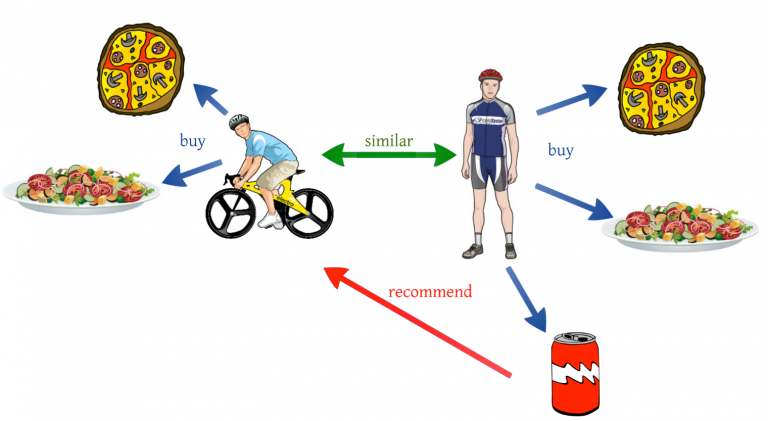

src. Medium

## Recommendation system using collaborative filtering 

For our collaborative filtering based recommendation system we computed the preferences of each reviewer and then tried to predict the rating for each beer for beers that the user has not rated previously.  Based on these predictions, we then recommended beers that the user hasn't tried before and he may like.


#### Data Matrix Creation: 
Our rows are the beerIDs and the columns correspond to user ratings. Each cell in the matrix correspond to a beer and the overall rating for that beer by the user in that column. Since not every user has rated every beer a lot of cells are zeros.  

#### Feature Matrix Creation:
Feature matrix rows are beer IDs and columns are features. It contains four features - appearance,aroma, palate, taste. The data in the columns corresponds to a particular beer ID in the sample means of each feature from all the ratings given for that beer ID. We assumed that the mean rating is proportional to the attributes of a given beer. We did not use ABV as one of our features because it has way too many undefined values and when we tried to use it it shrank our feature set too much. 

#### Data Cleaning Procedure: 
1. We created user information based on review_profile name. We dropped rows with missing "review_profile name" from the data matrix.
2. We then used this reduced dataset that satisfied our minimum number of samples required to predict population means with 95% confidence level given a sample standard deviation and margin of error. 
3. We then used the sample means for each of the main beer attributes: aroma, palette, appearance and taste.
4. Overall_reviews are the beer reviews given by a user.

### Building our Feature Matrix

In [9]:
# Feature Matrix(dataframe)
feature_df = beer_data[["beer_beerid", "review_profilename",'review_appearance','review_aroma', 
                      'review_palate','review_taste','review_overall']]
feature_df = feature_df.drop_duplicates(["beer_beerid","review_profilename"])
feature_df = feature_df.set_index("beer_beerid")

#here we discard the beers that didn't meet screening at 95% confidence interval
feature_df = feature_df.drop(discard_beer_ids)
feature_df = feature_df.reset_index()

# here we make a list that matches our data matrix index
beer_id_list = sorted(feature_df.beer_beerid.unique())
profile_list = feature_df.review_profilename.unique()

# here we re-index the dataframe so we can then extract the features we want.
feature_df = feature_df.set_index(["beer_beerid","review_profilename"])


In [11]:
# this computes the sample means for our features dataframe 
features_dictionary = feature_df.groupby(level=0).mean().to_dict()
appearance_sample_means = features_dictionary['review_appearance']
aroma_sample_means = features_dictionary['review_aroma']
palate_sample_means = features_dictionary['review_palate']
taste_sample_means = features_dictionary['review_taste']

# this constructs a numpy matrix with the sample means from our feature dataframe
feature_matrix = np.zeros(len(beer_id_list*5)).reshape(len(beer_id_list),5)
features_means_dictionarys = [appearance_sample_means,aroma_sample_means,
                      palate_sample_means,taste_sample_means]

# here we populate the first element of the feature matrix with beer IDs
for beer_index in range(len(beer_id_list)):
    feature_matrix[beer_index][0] = beer_id_list[beer_index]
    
feature_index = 1
for features_dictionary in features_means_dictionarys:
    for beer_index in range(len(beer_id_list)):
        for key in features_dictionary.keys():
            if key == beer_id_list[beer_index]:
                feature_matrix[beer_index][feature_index] = features_dictionary[key]
    feature_index += 1

# here we add a bias column in the feature matrix
# https://stackoverflow.com/questions/8486294/how-to-add-an-extra-column-to-a-numpy-array
feature_matrix = np.insert(feature_matrix,1,1, axis=1)

### Defining our Data Matrix (dataframe) and then using it to compute our user preferences

### WARNING: RUNNING THE FOLLOWING CELL LOCALLY CAN TAKE IN EXCESS OF 4 HOURS!!!

Constructing a data matrix with all users and all beers can take a lot of time and memory if done locally. It would be a good solution to take this notebook to some type of cloud computing machine. Alternatively it might be a good idea to create a pickle to be able to access it faster. To run it locally we took one block of users at a time and evaluated the paramater matrix that corresponded to their preferences. 

For the total number of users in the list approximately 30000 this can take about 4 hours. 
This is because it has to lookup the data  in the dataframe,generate x and y numpy arrays and then regress the data 



In [12]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import timeit

# instatiate a  dictionary object to hold profile names and corresponding user preference matrices
user_preferences = {}

# Generate user preferences for first block of 1000 users in the list
data_df = feature_df.drop(['review_appearance','review_aroma', 
                      'review_palate','review_taste'], axis=1)

#instantiate a dictionary object to hold our subset of profile names that meet our confidence threshhold  
best_scores = {}
for profile in profile_list[:1000]:
    data_matrix = np.zeros(len(beer_id_list*2)).reshape(len(beer_id_list),2)
    for beer_index in range(len(beer_id_list)):
        data_matrix[beer_index][0] = beer_id_list[beer_index]
        try:
            data_matrix[beer_index][1] = data_df.loc[beer_id_list[beer_index],profile].tolist()[0]
        except KeyError:
            data_matrix[beer_index][1] = 0.0
            
    # here we create X and y matrices that we can then feed into our simple linear regression model below 
    # however, we found that including all the rows resulted in a poor correlation 
    # for this reason we choose to include only rows which actually included full reviews 
    #  and we did not include the bias term
    
    y = np.array([data_matrix[i][1] for i in range(data_matrix.shape[0]) if data_matrix[i][1] > 0])
    X = np.array([feature_matrix[i][1:] for i in range(feature_matrix.shape[0]) if data_matrix[i][1] > 0])

    
    # linear regression to compute parameter matrix
    regressor = LinearRegression()
    regressor.fit(X,y)
    score = regressor.score(X,y)
    user_preferences[profile] = [regressor.coef_,score]
    
    # we will populate the dict with profile names whose scores are above a certain threshold
    if score > 0.5:
        best_scores[profile] = [profile,score]

#### Predicting beer reviews based on our Feature Matrix and user preferences

After populating our dictionary with user preferences we can predict what their ratings would be based on their past preferences

To test this we will take a user at random from out profile list and based on our prediction we will recommend other beers that they may like.

In [15]:
import random
#choose random user out of profiles list
if len(list(best_scores.keys())) > 0:
    profile_name  = list(best_scores.keys())[random.randrange(0,len(list(best_scores.keys())))]
    r2score = best_scores[profile_name][1]
else:
    profile_name = profile
    r2score = score

# List of beers not rated by the user
beers_not_rated = np.array([feature_matrix[i][0] for i in range(feature_matrix.shape[0])if data_matrix[i][1] == 0])

# Feature list of beers
X_not_rated = np.array([feature_matrix[i][1:] for i in range(feature_matrix.shape[0]) if data_matrix[i][1] == 0])

# computed user preferences from our regression analysis above
user_pref = user_preferences[profile_name][0]
user_pref = user_pref[:,np.newaxis]

# Compute predicted ratings for the user
y_pred_ratings = np.dot(X_not_rated, user_pref)

# We will cap the rating at 5.0 since our regression analysis has at times predicted values over 5 
for i in range(y_pred_ratings.shape[0]):
    if y_pred_ratings[i] > 5.0:
        y_pred_ratings[i] = 5.0

# prepare a new dataframe to display the top recommendations
pred_df = pd.DataFrame()

# Add two new columns to display results
pred_df['beerID'] = [int(beers_not_rated[i]) for i in range(beers_not_rated.shape[0])]
pred_df['predRating'] = [y_pred_ratings[i][0] for i in range(beers_not_rated.shape[0])]

# Sort in descending order. Main column is the predicted overall rating
pred_df.sort_values(by='predRating', ascending=False, inplace=True)

#Extract beer IDs to collect beerName and beerStyle information from original dataFrame 
pred_beer_ids = pred_df.beerID.tolist() 

# Add other columns to the recommendation dataframe
avg_appearance = [appearance_sample_means[i] for i in pred_beer_ids]
avg_aroma = [aroma_sample_means[i] for i in pred_beer_ids]
avg_palate = [palate_sample_means[i] for i in pred_beer_ids]
avg_taste = [taste_sample_means[i] for i in pred_beer_ids]
beer_names = [beer_data[beer_data.beer_beerid == i].beer_name.tolist()[0] for i in pred_beer_ids]
brewery_names = [beer_data[beer_data.beer_beerid == i].brewery_name.tolist()[0] for i in pred_beer_ids]
beer_styles = [beer_data[beer_data.beer_beerid == i].beer_style.tolist()[0] for i in pred_beer_ids]
pred_df['Aroma'] = avg_aroma
pred_df['Appearance'] = avg_appearance
pred_df['Palate'] = avg_palate
pred_df['Taste'] = avg_taste
pred_df['BeerName'] = beer_names
pred_df['BreweryName'] = brewery_names
pred_df['BeerStyle'] = beer_styles

### Our top recommendations for the selected user

In [17]:
print ("ProfileName: ", profile_name)
print ("R$^2$ value: ",r2score)
top_recommendations = pred_df.head(10).set_index("BeerName")
top_recommendations.drop("beerID", axis=1, inplace=True)
top_recommendations

ProfileName:  Popkas
R$^2$ value:  0.5017833817099286


,predRating,Aroma,Appearance,Palate,Taste,BreweryName,BeerStyle
BeerName,,,,,,,
Sierra Nevada Ruthless Rye IPA,5.0,3.950000,4.110000,3.940000,4.010000,Sierra Nevada Brewing Co.,Rye Beer
Duck-Rabbit Rabid Duck,5.0,4.042045,4.137500,3.943182,3.976136,The Duck-Rabbit Craft Brewery,Russian Imperial Stout
Ettaler Curator Doppelbock (US Import Version),5.0,3.966867,3.822289,3.927711,3.945783,Klosterbrauerei Ettal / Ettaler Klosterbetrieb...,Doppelbock
Ten Years Alt,5.0,3.835341,4.000000,3.981928,3.989960,Victory Brewing Company,Altbier
Duet IPA,5.0,4.391304,4.198370,4.108696,4.315217,Alpine Beer Company,American IPA
Hoppyum IPA,5.0,3.734536,4.007732,3.847938,3.835052,Foothills Brewing Company,American IPA
"Fuego Del Otono, Autumn Fire",5.0,4.115385,4.205128,3.958333,4.102564,Jolly Pumpkin Artisan Ales,Bière de Garde
Gratitude,5.0,4.280749,4.163102,4.211230,4.374332,East End Brewing Company,American Barleywine
AleSmith Grand Cru Ale,5.0,4.080189,3.949686,4.047170,4.160377,AleSmith Brewing Company,Belgian Strong Dark Ale


### References:
1. https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
2. https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed
3. https://blog.statsbot.co/recommendation-system-algorithms-ba67f39ac9a3
4. https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
5. https://blog.dominodatalab.com/recommender-systems-collaborative-filtering/
6. https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101
7. https://beckernick.github.io/music_recommender/
8. https://medium.com/coinmonks/how-recommender-systems-works-python-code-850a770a656b